In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split # for splitting the training data

from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.ensemble import GradientBoostingRegressor as GBR


# for cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
Kfold_validation = KFold(10) # use k=10 for cross validation

# Calculate MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Load and validate the training and testing data

In [2]:
# Load the preprocessed training data
train_processed = pd.read_csv('train_processed.csv')
print("Training data shape:", train_processed.shape)
print("Columns:", train_processed.columns.tolist())

# Separate features (X) and target (y)
y_train = train_processed['Price']
X_train = train_processed.drop(columns=['Price'])


print(f"\nFeatures shape: {X_train.shape}")
print(f"Target shape: {y_train.shape}")
print(f"\nTarget statistics:")
print(f"Mean price: {y_train.mean():.2f}")
print(f"Min price: {y_train.min():.2f}")
print(f"Max price: {y_train.max():.2f}")

# Split data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)
print(f"Training set: {X_train_split.shape}")
print(f"Validation set: {X_val.shape}")

Training data shape: (4336, 21)
Columns: ['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'No. of Doors', 'Price', 'Age', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Fuel_Type_CNG', 'Fuel_Type_LPG', 'Transmission_Manual', 'Transmission_Automatic', 'Owner_Type_First', 'Owner_Type_Second', 'Owner_Type_Third', 'Owner_Type_Fourth & Above', 'Colour_Others', 'Colour_Black/Silver', 'Colour_White']

Features shape: (4336, 20)
Target shape: (4336,)

Target statistics:
Mean price: 9.65
Min price: 0.44
Max price: 160.00
Training set: (3468, 20)
Validation set: (868, 20)


# Random Forest Regressor model

In [3]:
# Train a Random Forest Regressor model
print("Training Random Forest model...")
rf_model = RF(n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1)

rf_model.fit(X_train_split, y_train_split)

# Make predictions
y_pred_val_rf = rf_model.predict(X_val)

# Evaluate the model
print("\n=== Random Forest Model Performance ===")
print(f"Validation MAPE: {calculate_mape(y_val, y_pred_val_rf):.2f}%")

# perform cross validation to evaluate the testing error
rf_model_cross_validation_result = cross_val_score(rf_model,X_train,y_train,cv = Kfold_validation)

print("\n=== Cross validation result ===")
print(rf_model_cross_validation_result)
print("\n=== Cross validation mean score ===")
print(np.mean(rf_model_cross_validation_result))

Training Random Forest model...

=== Random Forest Model Performance ===
Validation MAPE: 19.11%

=== Cross validation result ===
[0.87836989 0.78240866 0.82304003 0.9111902  0.87047125 0.8946231
 0.8554626  0.9052574  0.90436449 0.83461941]

=== Cross validation mean score ===
0.8659807041400704


In [4]:
# Load test_processed.csv and predict the price
test_processed = pd.read_csv('test_processed.csv')
print("Test data shape:", test_processed.shape)
print("Test data columns:", test_processed.columns.tolist())

# Save ID column if it exists
X_test = test_processed.drop(columns=['ID'])

print(f"\nTest features shape: {X_test.shape}")
print(f"Training features shape: {X_train.shape}")

# Verify columns match between train and test
print(f"\nColumns match: {list(X_train.columns) == list(X_test.columns)}")

Test data shape: (1491, 21)
Test data columns: ['ID', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'No. of Doors', 'Age', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Fuel_Type_CNG', 'Fuel_Type_LPG', 'Transmission_Manual', 'Transmission_Automatic', 'Owner_Type_First', 'Owner_Type_Second', 'Owner_Type_Third', 'Owner_Type_Fourth & Above', 'Colour_Others', 'Colour_Black/Silver', 'Colour_White']

Test features shape: (1491, 20)
Training features shape: (4336, 20)

Columns match: True


In [5]:
# Make predictions using Random Forest model
y_pred_rf = rf_model.predict(X_test)

print("=== Random Forest Predictions ===")
print(f"Predicted prices - Min: {y_pred_rf.min():.2f}, Max: {y_pred_rf.max():.2f}, Mean: {y_pred_rf.mean():.2f}")

# Save ID and predicted Price to CSV file
submission_dt = pd.DataFrame({
    'ID': test_processed['ID'],
    'Price': y_pred_rf
})

submission_dt.to_csv('submission_random_tree_forest.csv', index=False)
print("\nDecision Tree submission saved as submission_random_tree_forest.csv")

=== Random Forest Predictions ===
Predicted prices - Min: 0.83, Max: 71.35, Mean: 9.67

Decision Tree submission saved as submission_random_tree_forest.csv



=== Top 15 Most Important Features (XGBoost) ===
               feature  importance
                 Power    0.702756
                   Age    0.167616
     Kilometers_Driven    0.041446
                Engine    0.038916
               Mileage    0.022450
                 Seats    0.006433
          Colour_White    0.005552
   Transmission_Manual    0.003998
Transmission_Automatic    0.003966
          No. of Doors    0.001767
      Fuel_Type_Diesel    0.001175
         Colour_Others    0.001173
   Colour_Black/Silver    0.000937
      Fuel_Type_Petrol    0.000755
      Owner_Type_First    0.000753


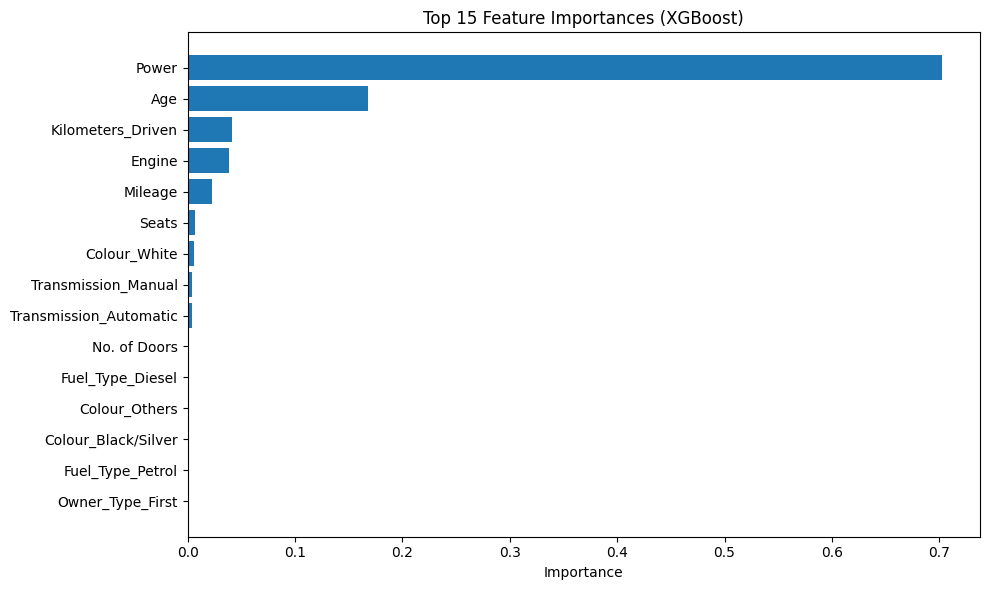

In [6]:
# Feature importance from XGBoost
import matplotlib.pyplot as plt

feature_importance_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== Top 15 Most Important Features (XGBoost) ===")
print(feature_importance_xgb.head(15).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_xgb.head(15)['feature'], feature_importance_xgb.head(15)['importance'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()